In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

sess =tf.Session()

In [2]:
mnist = tf.keras.datasets.mnist
(train_data,train_label),(test_data,test_label) = mnist.load_data()

In [3]:
#normalizing data
train_data = train_data/256.0
test_data = test_data/256.0

In [4]:
N_train = train_data.shape[0]
N_test = test_data.shape[0]
data_dim = train_data.shape[1]
minibatch_size = 1000

In [5]:
class convLayer:
    def __init__(self,fil_w,fil_h,in_chan,out_chan,strides=[1,1,1,1],pad="SAME"):
        self.fil_w = fil_w
        self.fil_h = fil_h
        self.strides = strides
        self.padding = pad
        self.filters = tf.Variable(tf.truncated_normal([fil_h,fil_w,in_chan,out_chan],stddev=0.1))
        self.bias = tf.Variable(np.zeros(out_chan))
    
    def layer_output(self,inp):
        return tf.nn.conv2d(inp,self.filters,self.strides,self.padding)
        

In [6]:
class poolLayer:
    def __init__(self,win_shape,strides=None,pool="MAX",pad="SAME"):
        self.win_shape = win_shape
        self.padding = pad
        self.strides = strides
        self.pool_type = pool
        
    def layer_output(self,inp):
        return tf.nn.pool(inp,self.win_shape,self.pool_type,self.padding,strides=self.strides)

In [7]:
class reluLayer:
    def layer_output(self,inp):
        return tf.nn.relu(inp)

In [8]:
class fcLayer:
    def __init__(self,w,h,ch):
        self.W = tf.Variable(tf.truncated_normal([w*h*ch,10],stddev=0.1))
        
    def layer_output(self,inp):
        return tf.matmul(tf.layers.flatten(inp),self.W)

In [9]:
train_x = tf.placeholder(tf.float32,(minibatch_size,data_dim,data_dim))
train_y = tf.placeholder(tf.uint8,(minibatch_size,))

In [10]:
layer1 = convLayer(5,5,1,10)
layer2 = reluLayer()
layer3 = poolLayer([3,3])
layer4 = convLayer(3,3,10,10)
layer5 = reluLayer()
layer6 = poolLayer([5,5])
layer7 = fcLayer(28,28,10)

In [11]:
l1_out = layer1.layer_output(tf.expand_dims(train_x,-1))
l2_out = layer2.layer_output(l1_out)
l3_out = layer3.layer_output(l2_out)

l4_out = layer4.layer_output(l3_out)
l5_out = layer5.layer_output(l4_out)
l6_out = layer6.layer_output(l5_out)
l7_out = layer7.layer_output(l6_out)
output_value = l7_out

In [12]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(train_y,10),logits=output_value))

In [13]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [14]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

In [15]:
# minibatching because the training is super slow

loss_arr = []
for i in range(1000):
    rand_index = np.random.choice(N_train, size=minibatch_size)
    t_x = train_data[rand_index]
    t_y = train_label[rand_index]
    _, loss_value = sess.run((train,loss),feed_dict={train_x:t_x,train_y:t_y})
    loss_arr.append(loss_value)


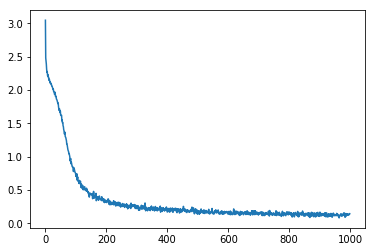

In [16]:
plt.plot(np.arange(0,1000),loss_arr)
plt.show()

In [17]:
def batch_eval(data,label):
    print(data.shape)
    
    ypred = []
    for i in range(int(data.shape[0]/1000)):
        
        t_x = data[i*1000:(i+1)*1000]
        t_y = label[i*1000:(i+1)*1000]   
        soft_pred = sess.run(output_value,feed_dict={train_x:t_x,train_y:t_y})
        pred = np.argmax(soft_pred,axis=1)
        ypred.append(pred)
    return np.reshape(np.array(ypred),(-1))

In [18]:
ypred = batch_eval(train_data,train_label)
print("Accuracy on training data: %.3f"%(np.mean(np.equal(ypred,train_label))*100))

(60000, 28, 28)
Accuracy on training data: 96.295


In [19]:
ypred = batch_eval(test_data,test_label)
print("Accuracy on training data: %.3f"%(np.mean(np.equal(ypred,test_label))*100))

(10000, 28, 28)
Accuracy on training data: 96.690
